## Step-Well

In [1]:
import wandb
import tensorflow as tf
import numpy as np
from gpflow.config import default_float
from gpflow.likelihoods import Gaussian
import matplotlib.pyplot as plt

from docs.sde.sde_exp_utils import euler_maruyama
from markovflow.sde.sde import StepWellSDE
from markovflow.models.vi_sde import VariationalMarkovGP

from docs.sde.t_vgp_trainer import tVGPTrainer

2022-08-26 15:20:52.578250: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-26 15:20:52.578298: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-08-26 15:20:54.305700: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-08-26 15:20:54.306986: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-08-26 15:20:54.327588: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2022-08-26 15:20:54.327628: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: verma
2022-08-26 15:20:54.327635: I tensorflow/stream_execut

In [2]:
wandb.init()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: prakharverma (vermaprakhar). Use `wandb login --relogin` to force relogin


In [3]:
DTYPE = default_float()

seed = 123
tf.random.set_seed(seed)
np.random.seed(seed)

## Setup

In [4]:
t0 = 0
t1 = 10
dt = 0.001
noise_var = 0.001
n_observations = 10

# Define q
q = 2.5 * tf.ones((1, 1), dtype=DTYPE)

# Generate observations.
sde = StepWellSDE(q=q)

x0_shape = (1, 1)
x0 = -0.5 + tf.zeros(x0_shape, dtype=DTYPE)

time_grid = tf.cast(np.linspace(t0, t1, int((t1 - t0) // dt) + 2), dtype=DTYPE)

observation_idx = list(tf.cast(np.linspace(2, time_grid.shape[0] - 2, n_observations), dtype=tf.int32))
obs_t = tf.gather(time_grid, observation_idx)

latent_process = euler_maruyama(sde, x0, time_grid)
latent_states = tf.gather(latent_process, observation_idx, axis=1)
# Adding observation noise
obs_val = latent_states + tf.random.normal(latent_states.shape, stddev=np.sqrt(noise_var), dtype=DTYPE)

obs_val = tf.reshape(obs_val, (-1, 1))

observations = (obs_t, obs_val)
likelihood = Gaussian(variance=noise_var)

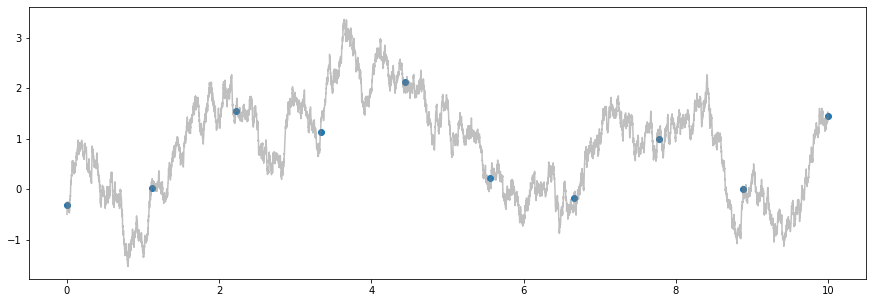

In [5]:
plt.subplots(1, 1, figsize=(15, 5))

plt.scatter(observations[0].numpy().reshape(-1), observations[1].numpy().reshape(-1))
plt.plot(time_grid.numpy().reshape(-1), latent_process.numpy().reshape(-1),color="gray", alpha=0.5)

plt.show()

## T-VGP Trainer

In [6]:
t_vgp_trainer_all_sites = tVGPTrainer(observations, likelihood, time_grid, sde, data_sites_lr=1.0, 
                                      update_all_sites=True)
t_vgp_trainer_all_sites.run()

2022-08-26 15:21:19.443989: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


t-VGP: Starting ELBO -7224.6437857181345;
t-VGP: Updating sites...
t-VGP: ELBO = -15.713151934019352
t-VGP: ELBO = -15.713151934019354
t-VGP: Sites converged! Linearizing...
t-VGP: ELBO before linearization -15.713151934019354!!!
t-VGP: ELBO after linearization -14.829370983958942!!!
ELBO diff : 0.8837809562683105 


t-VGP: ELBO before linearization -14.829370983958942!!!
t-VGP: ELBO after linearization -14.920127318810362!!!
ELBO decreasing!!!
ELBO diff : 0.09075633436441422 


t-VGP: ELBO before linearization -14.920127318810362!!!
t-VGP: ELBO after linearization -14.954366567672981!!!
ELBO decreasing!!!
ELBO diff : 0.03423924744129181 


t-VGP: ELBO before linearization -14.954366567672981!!!
t-VGP: ELBO after linearization -14.994791379367637!!!
ELBO decreasing!!!
ELBO diff : 0.04042481258511543 


t-VGP: ELBO before linearization -14.994791379367637!!!
t-VGP: ELBO after linearization -15.062063430961418!!!
ELBO decreasing!!!
ELBO diff : 0.06727205216884613 


t-VGP: ELBO before li

wandb: Network error (ConnectionError), entering retry loop.


t-VGP: ELBO after linearization -15.167442508392263!!!
ELBO decreasing!!!
ELBO diff : 0.008652199059724808 


t-VGP: ELBO before linearization -15.167442508392263!!!
t-VGP: ELBO after linearization -15.158790308952494!!!
ELBO diff : 0.008652199059724808 


t-VGP: ELBO before linearization -15.158790308952494!!!
t-VGP: ELBO after linearization -15.167442508392263!!!
ELBO decreasing!!!
ELBO diff : 0.008652199059724808 


t-VGP: ELBO before linearization -15.167442508392263!!!
t-VGP: ELBO after linearization -15.158790308952494!!!
ELBO diff : 0.008652199059724808 


t-VGP: ELBO before linearization -15.158790308952494!!!
t-VGP: ELBO after linearization -15.167442508392263!!!
ELBO decreasing!!!
ELBO diff : 0.008652199059724808 


t-VGP: ELBO before linearization -15.167442508392263!!!
t-VGP: ELBO after linearization -15.158790308952494!!!
ELBO diff : 0.008652199059724808 


t-VGP: ELBO before linearization -15.158790308952494!!!
t-VGP: ELBO after linearization -15.167442508392263!!!
ELBO d

([-7224.6437857181345,
  -15.713151934019352,
  -15.713151934019354,
  -14.829370983958942,
  -14.920127318810362,
  -14.954366567672981,
  -14.994791379367637,
  -15.062063430961418,
  -15.1058476419227,
  -15.121622665252643,
  -15.141806807037087,
  -15.145615766680335,
  -15.146916530880551,
  -15.161392808266173,
  -15.155562859682423,
  -15.166036625532287,
  -15.158862987183346,
  -15.16727362118818,
  -15.164246769879153,
  -15.158790308952494,
  -15.167442508392263,
  -15.158790308952494,
  -15.167442508392263,
  -15.158790308952494,
  -15.167442508392263,
  -15.158790308952494,
  -15.167442508392263,
  -15.164246769879151,
  -15.158790308952494,
  -15.167442508392263,
  -15.158790308952494,
  -15.167442508392263,
  -15.158790308952494,
  -15.167442508392263,
  -15.158790308952494,
  -15.167442508392263],
 {},
 {})

## Plot linearized Prior

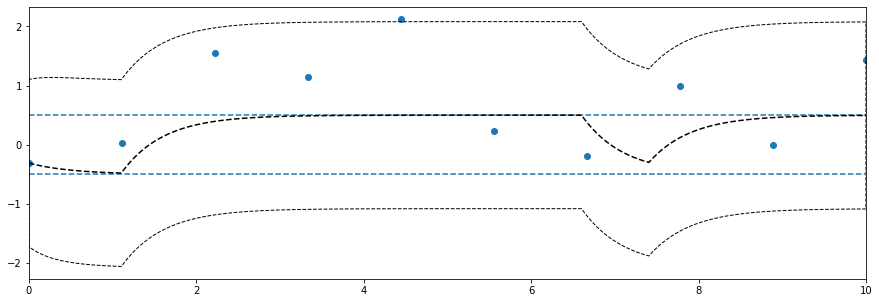

In [7]:
# Linearized prior
lin_m, lin_S = t_vgp_trainer_all_sites.tvgp_model.dist_p_ssm.marginals
lin_m = lin_m.numpy().reshape(-1)
lin_S_std = np.sqrt(lin_S.numpy()).reshape(-1)

# Plotting
plt.subplots(1, 1, figsize=(15, 5))
plt.scatter(observations[0].numpy().reshape(-1), observations[1].numpy().reshape(-1))
plt.fill_between(
    time_grid,
    y1=(lin_m.reshape(-1) - 2 * lin_S_std.reshape(-1)).reshape(-1, ),
    y2=(lin_m.reshape(-1) + 2 * lin_S_std.reshape(-1)).reshape(-1, ),
    edgecolor="black",
    facecolor=(0, 0, 0, 0.),
    linestyle='dashed'
)
plt.hlines(0.5, t0, t1, linestyles="dashed")
plt.hlines(-0.5, t0, t1, linestyles="dashed")

# plt.vlines(time_grid.numpy().reshape(-1), -2, 2, linestyle="dashed", color="gray")

plt.plot(time_grid.numpy().reshape(-1), lin_m.reshape(-1), color="black", linestyle="dashed")

plt.xlim([t0, t1])
plt.show()

## c = -b/A

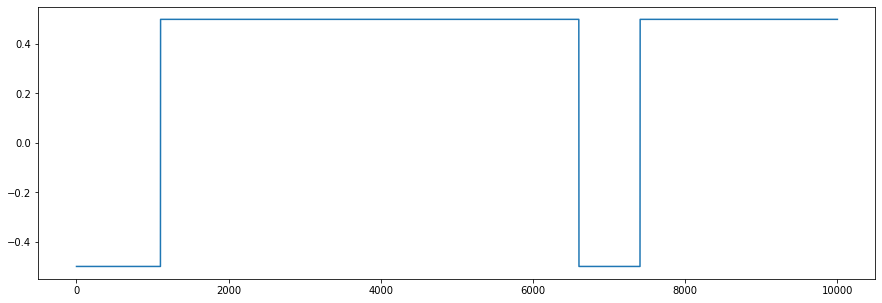

In [8]:
b = t_vgp_trainer_all_sites.tvgp_model.dist_p_ssm.state_offsets / dt
A = (t_vgp_trainer_all_sites.tvgp_model.dist_p_ssm.state_transitions - tf.eye(1, dtype=b.dtype)) / dt

A = A.numpy().reshape(-1)
b = b.numpy().reshape(-1)

plt.subplots(1, 1, figsize=(15, 5))
c = -b/A
plt.plot(c)
plt.show()

## Plot Posterior

In [9]:
m, S = t_vgp_trainer_all_sites.tvgp_model.dist_q.marginals
m = m.numpy().reshape(-1)
S_std = np.sqrt(S.numpy()).reshape(-1)

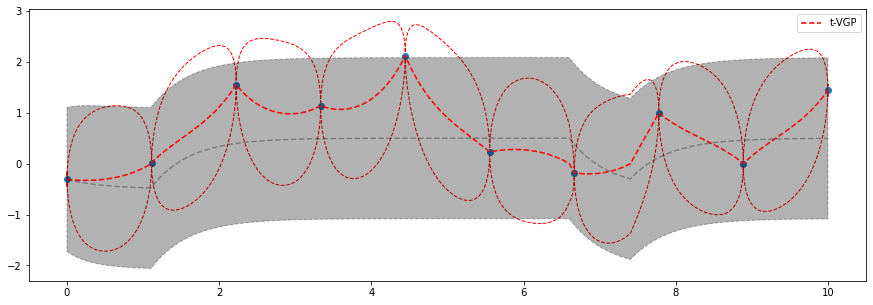

In [10]:
plt.subplots(1, 1, figsize=(15, 5))

plt.scatter(observations[0].numpy().reshape(-1), observations[1].numpy().reshape(-1))
plt.fill_between(
    time_grid,
    y1=(m.reshape(-1) - 2 * S_std.reshape(-1)).reshape(-1, ),
    y2=(m.reshape(-1) + 2 * S_std.reshape(-1)).reshape(-1, ),
    edgecolor="red",
    facecolor=(0, 0, 0, 0.),
    linestyle='dashed'
)

plt.plot(time_grid.numpy().reshape(-1), m.reshape(-1), color="red", linestyle="dashed", label="t-VGP")

plt.fill_between(
    time_grid,
    y1=(lin_m.reshape(-1) - 2 * lin_S_std.reshape(-1)).reshape(-1, ),
    y2=(lin_m.reshape(-1) + 2 * lin_S_std.reshape(-1)).reshape(-1, ),
    edgecolor="black",
    facecolor=(0, 0, 0, 0.),
    linestyle='dashed',
    alpha=0.3
)
plt.plot(time_grid.numpy().reshape(-1), lin_m.reshape(-1), color="black", linestyle="dashed", alpha=0.3)


plt.legend()
plt.show()


## VGP

In [11]:
vgp_model = VariationalMarkovGP(observations, sde, time_grid, likelihood, lr=0.0005, initial_state_lr=0.0001,
                                    convergence_tol=1e-4)

# Initialize VGP model
vgp_model.q_initial_cov = 0.5 + 0. * vgp_model.q_initial_cov
vgp_model.q_initial_mean = observations[1][0] + 0. * vgp_model.q_initial_mean
vgp_model.p_initial_mean = observations[1][0] + 0. * vgp_model.p_initial_mean
vgp_model.p_initial_cov = 0.5 + 0. * vgp_model.p_initial_cov

vgp_elbo_vals, _, _ = vgp_model.run(update_prior=False, update_initial_statistics=True)


VGP: Starting ELBO -11572.137964428506
VGP - q loop: ELBO -4486.680382140255
VGP - q loop: ELBO -3062.608733059048
VGP - q loop: ELBO -2366.423121152013
VGP - q loop: ELBO -1947.3714669927688
VGP - q loop: ELBO -1666.2444365748447
VGP - q loop: ELBO -1464.1697501784765
VGP - q loop: ELBO -1311.7348706410548
VGP - q loop: ELBO -1192.5446101655975
VGP - q loop: ELBO -1096.726067956931
VGP - q loop: ELBO -1017.9661389927256
VGP - q loop: ELBO -952.0368356758995
VGP - q loop: ELBO -896.0049615424615
VGP - q loop: ELBO -847.7653453091768
VGP - q loop: ELBO -805.7727129235117
VGP - q loop: ELBO -768.8662982675154
VGP - q loop: ELBO -736.1518779895484
VGP - q loop: ELBO -706.9380291789131
VGP - q loop: ELBO -680.6764466320284
VGP - q loop: ELBO -656.9267943128915
VGP - q loop: ELBO -635.3349235014808
VGP - x0 loop: ELBO -635.3122860793638
VGP - q loop: ELBO -615.5844749580286
VGP - q loop: ELBO -597.4821219947415
VGP - q loop: ELBO -580.7989521730777
VGP - q loop: ELBO -565.3695615606474
VGP 

VGP - q loop: ELBO -147.90012799813294
VGP - q loop: ELBO -147.34291586413485
VGP - q loop: ELBO -146.78984022906863
VGP - q loop: ELBO -146.24084209112024
VGP - q loop: ELBO -145.69623871252307
VGP - q loop: ELBO -145.15529199339997
VGP - q loop: ELBO -144.6184449829222
VGP - q loop: ELBO -144.08544019962616
VGP - q loop: ELBO -143.55633104923572
VGP - q loop: ELBO -143.03108052074472
VGP - q loop: ELBO -142.50961328677147
VGP - q loop: ELBO -141.99196313230942
VGP - q loop: ELBO -141.47806572252534
VGP - q loop: ELBO -140.96779096024667
VGP - q loop: ELBO -140.46125509380295
VGP - q loop: ELBO -139.9571532735403
VGP - q loop: ELBO -139.45787847333955
VGP - q loop: ELBO -138.96217385415932
VGP - x0 loop: ELBO -138.95255193099695
VGP - q loop: ELBO -138.4608058673367
VGP - q loop: ELBO -137.9721756754194
VGP - q loop: ELBO -137.48650604305496
VGP - q loop: ELBO -137.00478607546384
VGP - q loop: ELBO -136.52633384116115
VGP - q loop: ELBO -136.05172115713802
VGP - q loop: ELBO -135.5801

VGP - q loop: ELBO -86.18732796782389
VGP - q loop: ELBO -86.04105734094759
VGP - q loop: ELBO -85.89589653903094
VGP - q loop: ELBO -85.7515495014681
VGP - q loop: ELBO -85.60808485583378
VGP - q loop: ELBO -85.46573109227765
VGP - q loop: ELBO -85.32455467949944
VGP - q loop: ELBO -85.1840165887316
VGP - q loop: ELBO -85.04443895787074
VGP - q loop: ELBO -84.90579960189287
VGP - q loop: ELBO -84.76809413388861
VGP - q loop: ELBO -84.63140768724327
VGP - q loop: ELBO -84.49568948441981
VGP - q loop: ELBO -84.36074503064253
VGP - q loop: ELBO -84.22673128096746
VGP - x0 loop: ELBO -84.22106818740761
VGP - q loop: ELBO -84.08813468360073
VGP - q loop: ELBO -83.9558826959748
VGP - q loop: ELBO -83.82492593446447
VGP - q loop: ELBO -83.69468010897097
VGP - q loop: ELBO -83.5651671799401
VGP - q loop: ELBO -83.43671129676633
VGP - q loop: ELBO -83.30918290070963
VGP - q loop: ELBO -83.18236488535403
VGP - q loop: ELBO -83.05642753646401
VGP - q loop: ELBO -82.93136705179367
VGP - q loop: E

VGP - x0 loop: ELBO -72.36958746679036
VGP - x0 loop: ELBO -72.36469350668114
VGP - x0 loop: ELBO -72.35980004149381
VGP - x0 loop: ELBO -72.3549070711773
VGP - x0 loop: ELBO -72.35001459568473
VGP - x0 loop: ELBO -72.34512261496369
VGP - x0 loop: ELBO -72.34023112896651
VGP - x0 loop: ELBO -72.33534013764393
VGP - x0 loop: ELBO -72.33044964094452
VGP - x0 loop: ELBO -72.32555963881829
VGP - x0 loop: ELBO -72.32067013122354
VGP - x0 loop: ELBO -72.31578111810009
VGP - x0 loop: ELBO -72.31089259939954
VGP - x0 loop: ELBO -72.30600457508028
VGP - x0 loop: ELBO -72.30111704508705
VGP - x0 loop: ELBO -72.29623000936989
VGP - x0 loop: ELBO -72.29134346788605
VGP - x0 loop: ELBO -72.28645742057058
VGP - x0 loop: ELBO -72.2815718673879
VGP - x0 loop: ELBO -72.27668680828835
VGP - x0 loop: ELBO -72.2718022432106
VGP - x0 loop: ELBO -72.26691817212387
VGP - x0 loop: ELBO -72.26203459495521
VGP - x0 loop: ELBO -72.25715151167805
VGP - x0 loop: ELBO -72.2522689222278
VGP - x0 loop: ELBO -72.24738

VGP - x0 loop: ELBO -71.40114046670058
VGP - x0 loop: ELBO -71.39634535654477
VGP - x0 loop: ELBO -71.39155073071665
VGP - x0 loop: ELBO -71.38675658916756
VGP - x0 loop: ELBO -71.38196293185732
VGP - x0 loop: ELBO -71.37716975872415
VGP - x0 loop: ELBO -71.37237706973146
VGP - x0 loop: ELBO -71.36758486481952
VGP - x0 loop: ELBO -71.36279314394716
VGP - x0 loop: ELBO -71.35800190707285
VGP - x0 loop: ELBO -71.35321115413142
VGP - x0 loop: ELBO -71.34842088508422
VGP - x0 loop: ELBO -71.3436310998846
VGP - x0 loop: ELBO -71.33884179848133
VGP - x0 loop: ELBO -71.33405298082914
VGP - x0 loop: ELBO -71.32926464687499
VGP - x0 loop: ELBO -71.32447679657201
VGP - x0 loop: ELBO -71.31968942987127
VGP - x0 loop: ELBO -71.3149025467257
VGP - x0 loop: ELBO -71.31011614708753
VGP - x0 loop: ELBO -71.3053302309081
VGP - x0 loop: ELBO -71.300544798141
VGP - x0 loop: ELBO -71.29575984872992
VGP - x0 loop: ELBO -71.29097538263439
VGP - x0 loop: ELBO -71.28619139980653
VGP - x0 loop: ELBO -71.281407

VGP - x0 loop: ELBO -70.4378890647065
VGP - x0 loop: ELBO -70.43319151865337
VGP - x0 loop: ELBO -70.42849444718527
VGP - x0 loop: ELBO -70.42379785024222
VGP - x0 loop: ELBO -70.41910172778816
VGP - x0 loop: ELBO -70.41440607976548
VGP - x0 loop: ELBO -70.40971090613023
VGP - x0 loop: ELBO -70.40501620684145
VGP - x0 loop: ELBO -70.40032198184647
VGP - x0 loop: ELBO -70.39562823108996
VGP - x0 loop: ELBO -70.39093495454125
VGP - x0 loop: ELBO -70.38624215214291
VGP - x0 loop: ELBO -70.38152565867317
VGP - x0 loop: ELBO -70.37683380405309
VGP - x0 loop: ELBO -70.37214242344572
VGP - x0 loop: ELBO -70.36745151680337
VGP - x0 loop: ELBO -70.36276108407047
VGP - x0 loop: ELBO -70.35807112520725
VGP - x0 loop: ELBO -70.3533816401628
VGP - x0 loop: ELBO -70.34869262889246
VGP - x0 loop: ELBO -70.34400409134768
VGP - x0 loop: ELBO -70.33931602747934
VGP - x0 loop: ELBO -70.33462843724719
VGP - x0 loop: ELBO -70.329941320593
VGP - x0 loop: ELBO -70.32525467747735
VGP - x0 loop: ELBO -70.32056

VGP - x0 loop: ELBO -69.49427437549339
VGP - x0 loop: ELBO -69.48967242872378
VGP - x0 loop: ELBO -69.4850709469793
VGP - x0 loop: ELBO -69.48046993020657
VGP - x0 loop: ELBO -69.47586937837396
VGP - x0 loop: ELBO -69.47126929141523
VGP - x0 loop: ELBO -69.46666966930349
VGP - x0 loop: ELBO -69.4620705119851
VGP - x0 loop: ELBO -69.45747181940887
VGP - x0 loop: ELBO -69.45287359152863
VGP - x0 loop: ELBO -69.4482758283039
VGP - x0 loop: ELBO -69.44367852968813
VGP - x0 loop: ELBO -69.43908169562927
VGP - x0 loop: ELBO -69.43448532608375
VGP - x0 loop: ELBO -69.42988942100779
VGP - x0 loop: ELBO -69.42529398035457
VGP - x0 loop: ELBO -69.42069900406865
VGP - x0 loop: ELBO -69.41610449211232
VGP - x0 loop: ELBO -69.4115104444387
VGP - x0 loop: ELBO -69.40691686100075
VGP - x0 loop: ELBO -69.40232374174985
VGP - x0 loop: ELBO -69.39773108664401
VGP - x0 loop: ELBO -69.39313889562912
VGP - x0 loop: ELBO -69.38854716866814
VGP - x0 loop: ELBO -69.38395590571035
VGP - x0 loop: ELBO -69.37936

VGP - x0 loop: ELBO -68.56994865502367
VGP - x0 loop: ELBO -68.56544038294635
VGP - x0 loop: ELBO -68.56093256652856
VGP - x0 loop: ELBO -68.55642520573106
VGP - x0 loop: ELBO -68.55191830049971
VGP - x0 loop: ELBO -68.54741185080222
VGP - x0 loop: ELBO -68.5429058565816
VGP - x0 loop: ELBO -68.53840031779372
VGP - x0 loop: ELBO -68.53389523440012
VGP - x0 loop: ELBO -68.52939060635028
VGP - x0 loop: ELBO -68.5248864335948
VGP - x0 loop: ELBO -68.52038271609929
VGP - x0 loop: ELBO -68.5158794538069
VGP - x0 loop: ELBO -68.51137664667482
VGP - x0 loop: ELBO -68.50687429466299
VGP - x0 loop: ELBO -68.50237239772494
VGP - x0 loop: ELBO -68.49787095580604
VGP - x0 loop: ELBO -68.49336996886979
VGP - x0 loop: ELBO -68.48886943687026
VGP - x0 loop: ELBO -68.48436935975946
VGP - x0 loop: ELBO -68.4798697374927
VGP - x0 loop: ELBO -68.47537057002465
VGP - x0 loop: ELBO -68.47087185730791
VGP - x0 loop: ELBO -68.4663735993014
VGP - x0 loop: ELBO -68.46187579595313
VGP - x0 loop: ELBO -68.457378

VGP - x0 loop: ELBO -67.66439014767911
VGP - x0 loop: ELBO -67.65997362987358
VGP - x0 loop: ELBO -67.65555755856329
VGP - x0 loop: ELBO -67.65114193369882
VGP - x0 loop: ELBO -67.64672675523879
VGP - x0 loop: ELBO -67.64231202314066
VGP - x0 loop: ELBO -67.63789773735337
VGP - x0 loop: ELBO -67.63348389784007
VGP - x0 loop: ELBO -67.6290705045492
VGP - x0 loop: ELBO -67.62465755744256
VGP - x0 loop: ELBO -67.62024505647227
VGP - x0 loop: ELBO -67.6158330015934
VGP - x0 loop: ELBO -67.61142139276133
VGP - x0 loop: ELBO -67.60701022993081
VGP - x0 loop: ELBO -67.60259951306377
VGP - x0 loop: ELBO -67.59818924210411
VGP - x0 loop: ELBO -67.59377941701584
VGP - x0 loop: ELBO -67.58937003775812
VGP - x0 loop: ELBO -67.58492604006187
VGP - x0 loop: ELBO -67.58051755229546
VGP - x0 loop: ELBO -67.57610951021682
VGP - x0 loop: ELBO -67.57170191378769
VGP - x0 loop: ELBO -67.56729476295878
VGP - x0 loop: ELBO -67.56288805768928
VGP - x0 loop: ELBO -67.55848179792838
VGP - x0 loop: ELBO -67.554

VGP - x0 loop: ELBO -66.77711179648544
VGP - x0 loop: ELBO -66.77278511366251
VGP - x0 loop: ELBO -66.7684588683539
VGP - x0 loop: ELBO -66.76413306052117
VGP - x0 loop: ELBO -66.75980769011355
VGP - x0 loop: ELBO -66.75548275709406
VGP - x0 loop: ELBO -66.75115826141452
VGP - x0 loop: ELBO -66.74683420303246
VGP - x0 loop: ELBO -66.74251058190397
VGP - x0 loop: ELBO -66.73818739798685
VGP - x0 loop: ELBO -66.73386465123738
VGP - x0 loop: ELBO -66.72954234160918
VGP - x0 loop: ELBO -66.725220469059
VGP - x0 loop: ELBO -66.72089903354401
VGP - x0 loop: ELBO -66.716578035021
VGP - x0 loop: ELBO -66.71225747344974
VGP - x0 loop: ELBO -66.70793734877827
VGP - x0 loop: ELBO -66.70361766096983
VGP - x0 loop: ELBO -66.69929840997757
VGP - x0 loop: ELBO -66.69497959576113
VGP - x0 loop: ELBO -66.69066121827235
VGP - x0 loop: ELBO -66.68634327747111
VGP - x0 loop: ELBO -66.68202577331081
VGP - x0 loop: ELBO -66.67770870575373
VGP - x0 loop: ELBO -66.67339207474795
VGP - x0 loop: ELBO -66.669075

VGP - x0 loop: ELBO -65.90796138993166
VGP - x0 loop: ELBO -65.90372273699127
VGP - x0 loop: ELBO -65.89948451276449
VGP - x0 loop: ELBO -65.89524671721728
VGP - x0 loop: ELBO -65.89100935030716
VGP - x0 loop: ELBO -65.8867724119821
VGP - x0 loop: ELBO -65.88253590220619
VGP - x0 loop: ELBO -65.87829982093568
VGP - x0 loop: ELBO -65.87406416813303
VGP - x0 loop: ELBO -65.86982894374374
VGP - x0 loop: ELBO -65.86559414773238
VGP - x0 loop: ELBO -65.86135978005385
VGP - x0 loop: ELBO -65.85712584066724
VGP - x0 loop: ELBO -65.85289232953116
VGP - x0 loop: ELBO -65.8486592466002
VGP - x0 loop: ELBO -65.84442659183152
VGP - x0 loop: ELBO -65.84019436518432
VGP - x0 loop: ELBO -65.83596256661488
VGP - x0 loop: ELBO -65.83173119607791
VGP - x0 loop: ELBO -65.82750025353106
VGP - x0 loop: ELBO -65.82326973893402
VGP - x0 loop: ELBO -65.81903965224423
VGP - x0 loop: ELBO -65.81480999341838
VGP - x0 loop: ELBO -65.81058076241264
VGP - x0 loop: ELBO -65.8063519591832
VGP - x0 loop: ELBO -65.8021

VGP - x0 loop: ELBO -65.05651650846615
VGP - x0 loop: ELBO -65.05236411614115
VGP - x0 loop: ELBO -65.04821214391723
VGP - x0 loop: ELBO -65.04406059174778
VGP - x0 loop: ELBO -65.03990945959819
VGP - x0 loop: ELBO -65.03575874742191
VGP - x0 loop: ELBO -65.03160845517506
VGP - x0 loop: ELBO -65.0274585828178
VGP - x0 loop: ELBO -65.0233091303103
VGP - x0 loop: ELBO -65.01916009760659
VGP - x0 loop: ELBO -65.01501148467005
VGP - x0 loop: ELBO -65.01086329145166
VGP - x0 loop: ELBO -65.00671551791334
VGP - x0 loop: ELBO -65.00256816401733
VGP - x0 loop: ELBO -64.99842122971339
VGP - x0 loop: ELBO -64.99427471496405
VGP - x0 loop: ELBO -64.9901286197314
VGP - x0 loop: ELBO -64.9859829439663
VGP - x0 loop: ELBO -64.98183768762964
VGP - x0 loop: ELBO -64.97769285067466
VGP - x0 loop: ELBO -64.97354843307231
VGP - x0 loop: ELBO -64.96940443476436
VGP - x0 loop: ELBO -64.96526085572687
VGP - x0 loop: ELBO -64.96111769590303
VGP - x0 loop: ELBO -64.95697495525366
VGP - x0 loop: ELBO -64.95283

VGP - x0 loop: ELBO -64.22242125049166
VGP - x0 loop: ELBO -64.21835338517087
VGP - x0 loop: ELBO -64.2142859315061
VGP - x0 loop: ELBO -64.21021888945383
VGP - x0 loop: ELBO -64.20615225897122
VGP - x0 loop: ELBO -64.20208604001925
VGP - x0 loop: ELBO -64.19802023255275
VGP - x0 loop: ELBO -64.19395483653955
VGP - x0 loop: ELBO -64.189889851929
VGP - x0 loop: ELBO -64.18582527868158
VGP - x0 loop: ELBO -64.18176111676203
VGP - x0 loop: ELBO -64.17769736612621
VGP - x0 loop: ELBO -64.17363402673122
VGP - x0 loop: ELBO -64.16957109853605
VGP - x0 loop: ELBO -64.16550858150127
VGP - x0 loop: ELBO -64.16144647558589
VGP - x0 loop: ELBO -64.15738478075224
VGP - x0 loop: ELBO -64.15332349694899
VGP - x0 loop: ELBO -64.14926262414272
VGP - x0 loop: ELBO -64.14520216229266
VGP - x0 loop: ELBO -64.14114211135507
VGP - x0 loop: ELBO -64.13708247128905
VGP - x0 loop: ELBO -64.13302324205526
VGP - x0 loop: ELBO -64.12896442361253
VGP - q loop: ELBO -64.1290350926395
VGP: Breaking q loop as ELBO c

VGP - x0 loop: ELBO -63.405293305683905
VGP - x0 loop: ELBO -63.40130826797113
VGP - x0 loop: ELBO -63.39732363364156
VGP - x0 loop: ELBO -63.393339402646525
VGP - x0 loop: ELBO -63.38935557494795
VGP - x0 loop: ELBO -63.385372150502185
VGP - x0 loop: ELBO -63.38138912927531
VGP - x0 loop: ELBO -63.3774065112242
VGP - x0 loop: ELBO -63.373424296306354
VGP - x0 loop: ELBO -63.369442484483955
VGP - x0 loop: ELBO -63.36546107571523
VGP - x0 loop: ELBO -63.36148006996106
VGP - x0 loop: ELBO -63.35749946718241
VGP - x0 loop: ELBO -63.35351926733832
VGP - x0 loop: ELBO -63.34953947038265
VGP - x0 loop: ELBO -63.34556007628271
VGP - x0 loop: ELBO -63.34158108499706
VGP - x0 loop: ELBO -63.33760249648194
VGP - x0 loop: ELBO -63.33362431070261
VGP - x0 loop: ELBO -63.32964652761198
VGP - x0 loop: ELBO -63.325669147174075
VGP - q loop: ELBO -63.325743200341876
VGP: Breaking q loop as ELBO converged!!!
VGP - x0 loop: ELBO -63.32176624773681
VGP - x0 loop: ELBO -63.317789697697414
VGP - x0 loop: E

VGP - x0 loop: ELBO -62.604857966848265
VGP - x0 loop: ELBO -62.60095409292078
VGP - x0 loop: ELBO -62.59705061425844
VGP - x0 loop: ELBO -62.593147530823906
VGP - x0 loop: ELBO -62.589244842577415
VGP - x0 loop: ELBO -62.58534254947999
VGP - x0 loop: ELBO -62.581440651489274
VGP - x0 loop: ELBO -62.57753914856835
VGP - x0 loop: ELBO -62.57363804067989
VGP - x0 loop: ELBO -62.569737327777766
VGP - x0 loop: ELBO -62.56583700983196
VGP - x0 loop: ELBO -62.56193708679315
VGP - x0 loop: ELBO -62.55803755862915
VGP - x0 loop: ELBO -62.55413842529634
VGP - x0 loop: ELBO -62.55023968675652
VGP - x0 loop: ELBO -62.54634134296936
VGP - x0 loop: ELBO -62.54244339389879
VGP - x0 loop: ELBO -62.53854583950279
VGP - q loop: ELBO -62.5386231988224
VGP: Breaking q loop as ELBO converged!!!
VGP - x0 loop: ELBO -62.53472606391893
VGP - x0 loop: ELBO -62.530829323606554
VGP - x0 loop: ELBO -62.52693297784874
VGP - x0 loop: ELBO -62.52303702660797
VGP - x0 loop: ELBO -62.51914146984345
VGP - x0 loop: ELB

VGP - x0 loop: ELBO -61.82071182765537
VGP - x0 loop: ELBO -61.81688748638027
VGP - x0 loop: ELBO -61.813063532427236
VGP - x0 loop: ELBO -61.80923996575825
VGP - x0 loop: ELBO -61.80541678632694
VGP - x0 loop: ELBO -61.80159399410429
VGP - x0 loop: ELBO -61.797771589043855
VGP - x0 loop: ELBO -61.79394957111147
VGP - x0 loop: ELBO -61.79012794026886
VGP - x0 loop: ELBO -61.78630669647253
VGP - x0 loop: ELBO -61.78248583968627
VGP - x0 loop: ELBO -61.77866536987467
VGP - x0 loop: ELBO -61.77484528699411
VGP - x0 loop: ELBO -61.771025591008545
VGP - x0 loop: ELBO -61.767206281879396
VGP - q loop: ELBO -61.76728686541121
VGP: Breaking q loop as ELBO converged!!!
VGP - x0 loop: ELBO -61.763467967650875
VGP - x0 loop: ELBO -61.759649456666374
VGP - x0 loop: ELBO -61.755831332422815
VGP - x0 loop: ELBO -61.75201359487425
VGP - x0 loop: ELBO -61.74819624398685
VGP - x0 loop: ELBO -61.744379279721294
VGP - x0 loop: ELBO -61.74056270203594
VGP - x0 loop: ELBO -61.73674651089917
VGP - x0 loop: 

In [12]:
print(f"VGP model : {vgp_elbo_vals[-1]}")

VGP model : -61.576815021538856


In [13]:
m_vgp, S_vgp = vgp_model.forward_pass
m_vgp = m_vgp.numpy().reshape(-1)
S_std_vgp = np.sqrt(S_vgp.numpy()).reshape(-1)

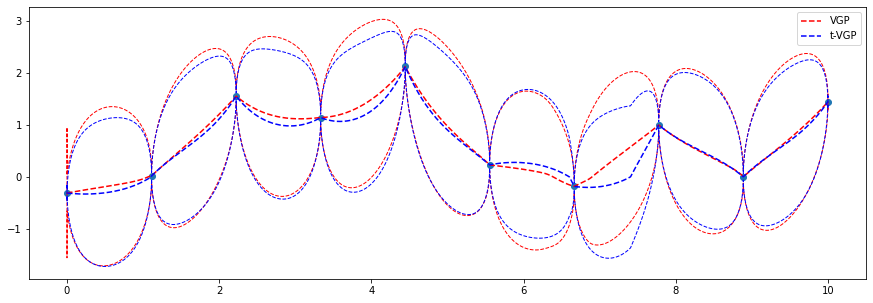

In [14]:
plt.subplots(1, 1, figsize=(15, 5))

plt.scatter(observations[0].numpy().reshape(-1), observations[1].numpy().reshape(-1))
plt.fill_between(
    time_grid,
    y1=(m_vgp.reshape(-1) - 2 * S_std_vgp.reshape(-1)).reshape(-1, ),
    y2=(m_vgp.reshape(-1) + 2 * S_std_vgp.reshape(-1)).reshape(-1, ),
    edgecolor="red",
    facecolor=(0, 0, 0, 0.),
    linestyle='dashed'
)

plt.plot(time_grid.numpy().reshape(-1), m_vgp.reshape(-1), color="red", linestyle="dashed", label="VGP")


plt.fill_between(
    time_grid,
    y1=(m.reshape(-1) - 2 * S_std.reshape(-1)).reshape(-1, ),
    y2=(m.reshape(-1) + 2 * S_std.reshape(-1)).reshape(-1, ),
    edgecolor="blue",
    facecolor=(0, 0, 0, 0.),
    linestyle='dashed'
)

plt.plot(time_grid.numpy().reshape(-1), m.reshape(-1), color="blue", linestyle="dashed", label="t-VGP")


plt.legend()
plt.show()
